In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from collections import defaultdict
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
load_train_1=pd.read_csv('/content/drive/MyDrive/NLP_Masters/Project/quora-question-pairs 2/train.csv')

In [ ]:
# Take 1% of the data from load_train_1
load_train = load_train_1#.sample(frac=0.01)

In [ ]:
load_train.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [ ]:
print(load_train.isna().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [ ]:
# dropping the missing values
load_train = load_train.dropna()
load_train.shape

(404287, 6)

In [ ]:
train_data, test_data = train_test_split(load_train, test_size=0.20,  random_state=203, stratify=load_train['is_duplicate'])

In [ ]:
train_data.shape

(323429, 6)

In [ ]:
test_data.shape

(80858, 6)

In [ ]:
tp1=minority_class_train = train_data[train_data['is_duplicate'] == 1]
tp1.shape

(119410, 6)

In [ ]:
tp2=minority_class_train = train_data[train_data['is_duplicate'] == 0]
tp2.shape

(204019, 6)

We are splitting train.csv file into 70/30 test train no validation.

In [ ]:
from sklearn.utils import resample

majority_class_train = train_data[train_data['is_duplicate'] == train_data['is_duplicate'].mode()[0]]
minority_class_train = train_data[train_data['is_duplicate'] != train_data['is_duplicate'].mode()[0]]

minority_class_train_upsampled = resample(minority_class_train,
                                          replace=True,
                                          n_samples=len(majority_class_train),
                                          random_state=42)

# Combine the balanced classes back
train_data = pd.concat([majority_class_train, minority_class_train_upsampled])

# Check new class distribution after balancing
print(train_data['is_duplicate'].value_counts())

is_duplicate
0    204019
1    204019
Name: count, dtype: int64


In [ ]:
train_data.shape

(408038, 6)

In [ ]:
print(train_data.columns)

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [ ]:
#print(load_test.columns)

In [ ]:
# Extract relevant columns for training
questions1 = train_data['question1'].fillna('').values  # Replace NaN with an empty string
questions2 = train_data['question2'].fillna('').values  # Replace NaN with an empty string
train_data['is_duplicate'].values  # Binary labels: 1 (duplicate), 0 (not duplicate)

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
X1_train = train_data['question1'].tolist()
X2_train = train_data['question2'].tolist()
X1_test = test_data['question1'].tolist()
X2_test = test_data['question2'].tolist()

y_train = train_data['is_duplicate'].values
y_test = test_data['is_duplicate'].values

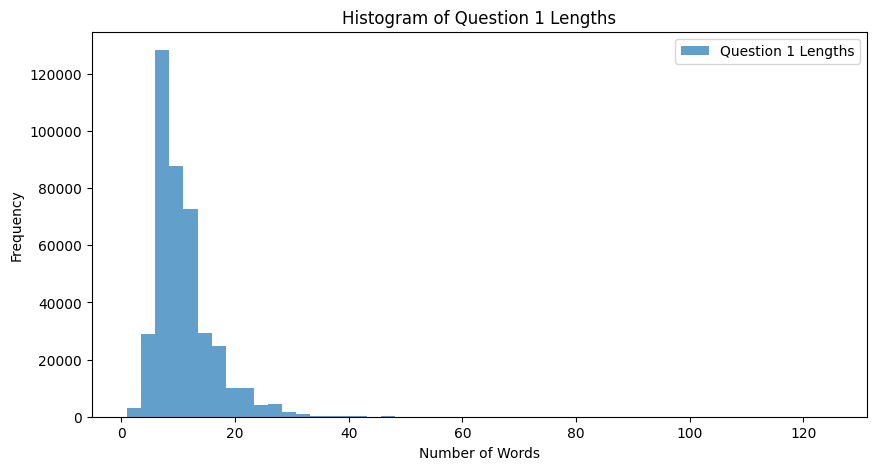

In [ ]:
import matplotlib.pyplot as plt

# Calculate the lengths of questions
questions1_lengths = [len(str(q).split()) for q in questions1]
questions2_lengths = [len(str(q).split()) for q in questions2]

# Plot histogram for question1
plt.figure(figsize=(10, 5))
plt.hist(questions1_lengths, bins=50, alpha=0.7, label='Question 1 Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Question 1 Lengths')
plt.legend()
plt.show()


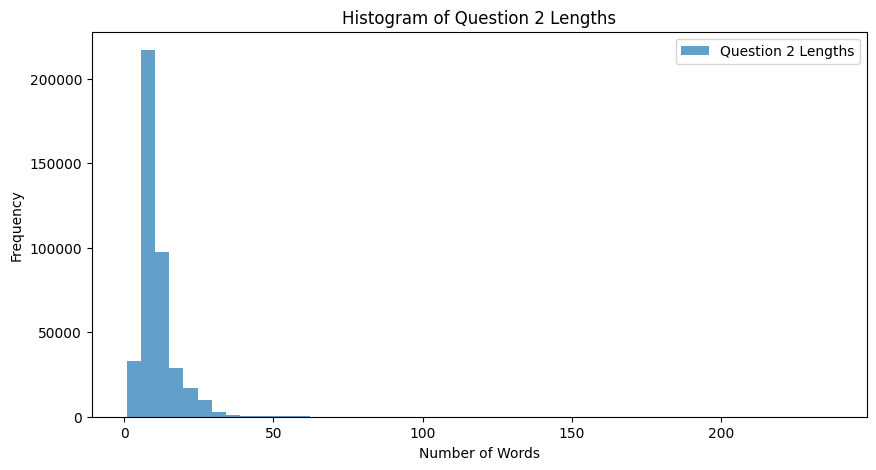

In [ ]:
# Plot histogram for question2
plt.figure(figsize=(10, 5))
plt.hist(questions2_lengths, bins=50, alpha=0.7, label='Question 2 Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Question 2 Lengths')
plt.legend()
plt.show()


Since most words are in between 0-40 let's keep the maximum length for sequence as 40

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
    return embeddings_index

In [ ]:
# Preprocess and tokenize text
tokenizer = Tokenizer()

def preprocess_text(train_data, glove_embeddings, max_length):
    tokenizer.fit_on_texts(
        list(train_data['question1'].fillna('')) + list(train_data['question2'].fillna(''))
    )
    word_index = tokenizer.word_index
    print(f"Vocabulary size: {len(word_index)}")

    vocab_size = len(word_index) + 1
    embedding_dim = glove_embeddings[list(glove_embeddings.keys())[0]].shape[0]

    # Create embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    print(f"Embedding matrix shape: {embedding_matrix.shape}")

    # Tokenize and pad sequences
    question1_seq = pad_sequences(tokenizer.texts_to_sequences(train_data['question1'].fillna('')),
                                   maxlen=max_length, padding='post', truncating='post')
    question2_seq = pad_sequences(tokenizer.texts_to_sequences(train_data['question2'].fillna('')),
                                   maxlen=max_length, padding='post', truncating='post')
    return question1_seq, question2_seq, word_index, embedding_matrix, vocab_size, embedding_dim


In [ ]:
# Define the LSTM encoder
def build_encoder_lstm(vocab_size, embedding_dim, embedding_matrix, input_length):
    model = tf.keras.Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False
        ),
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=True),
        LSTM(128),
        Dense(60, activation='tanh')
    ])
    return model

In [ ]:
# Define Siamese Network
def build_siamese_network_lstm(encoder, input_length):
    input_q1 = Input(shape=(input_length,))
    input_q2 = Input(shape=(input_length,))
    encoded_q1 = encoder(input_q1)
    encoded_q2 = encoder(input_q2)


    l2_distance = Lambda(lambda tensors: tf.sqrt(tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=1, keepdims=True)))([encoded_q1, encoded_q2]) # need to change

    dense = Dense(60, activation='tanh')(l2_distance)
    output = Dense(1, activation='sigmoid')(dense)
    siamese_network = Model(inputs=[input_q1, input_q2], outputs=output)
    return siamese_network

In [ ]:
glove_file = '/content/drive/MyDrive/NLP_Masters/Project/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file, embedding_dim=300)

Loaded 400000 word vectors from GloVe.


In [ ]:
# Preprocess text and get sequences
input_length = 40  # Adjust as per your needs
X1, X2, word_index, embedding_matrix, vocab_size, embedding_dim = preprocess_text(
    train_data, glove_embeddings, max_length=input_length
)

Vocabulary size: 85635
Embedding matrix shape: (85636, 300)


In [ ]:
# Build and compile the model
encoder = build_encoder_lstm(vocab_size, embedding_dim, embedding_matrix, input_length)
siamese_network = build_siamese_network_lstm(encoder, input_length)
siamese_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
y = train_data['is_duplicate'].values  # Ensure y is correctly loaded
history = siamese_network.fit([X1, X2], y, batch_size=64, epochs=1, validation_split=0.20)

5101/5101 ━━━━━━━━━━━━━━━━━━━━ 94s 17ms/step - accuracy: 0.6514 - loss: 0.6083 - val_accuracy: 0.6063 - val_loss: 0.8138


In [ ]:
from sklearn.metrics import roc_curve

y_train_pred = siamese_network.predict([X1, X2])

fpr, tpr, thresholds = roc_curve(y, y_train_pred)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")


12752/12752 ━━━━━━━━━━━━━━━━━━━━ 72s 6ms/step
Optimal Threshold: 0.39862287044525146


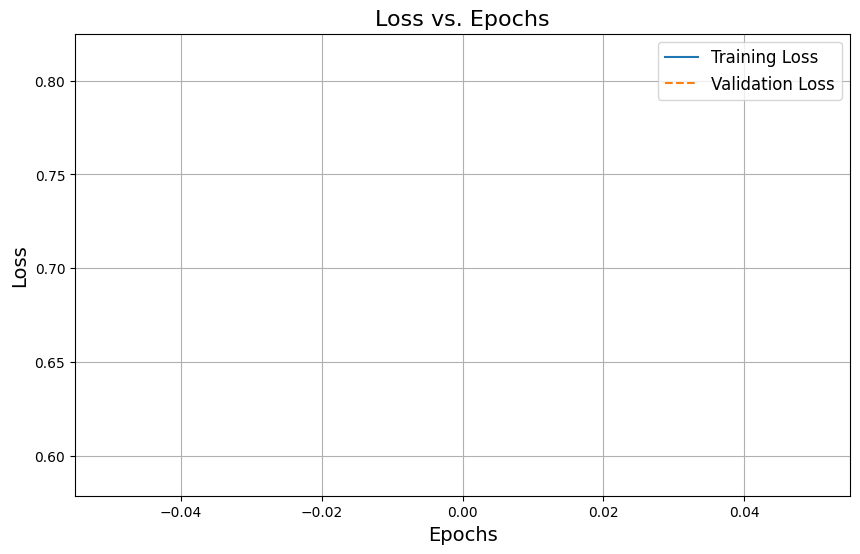

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title('Loss vs. Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_loss(history)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Function to compute and plot confusion matrix
def plot_confusion_matrix_lstm(model, X1, X2, y_true, dataset_type):
    # Get predictions
    y_pred = model.predict([X1, X2])
    y_pred_classes = (y_pred > optimal_threshold).astype(int).flatten() #change the threshold based on the optimised threshold we get

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for {dataset_type} Data', fontsize=16)
    plt.show()
    return y_pred_classes

12752/12752 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step


<Figure size 800x600 with 0 Axes>

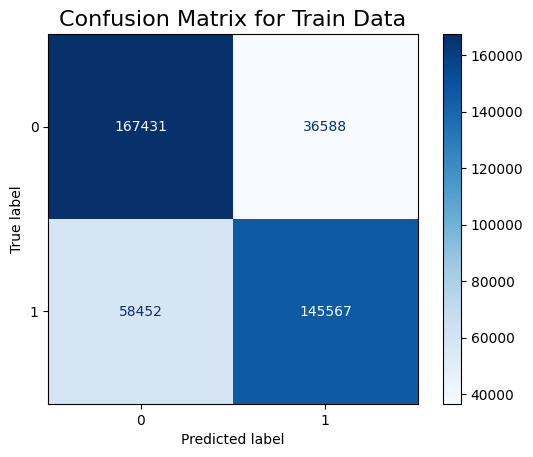

In [ ]:
# Confusion matrix for train data
y_pred_classes = plot_confusion_matrix_lstm(siamese_network, X1, X2, y, "Train")

In [ ]:
print(classification_report(y_train,y_pred_classes))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78    204019
           1       0.80      0.71      0.75    204019

    accuracy                           0.77    408038
   macro avg       0.77      0.77      0.77    408038
weighted avg       0.77      0.77      0.77    408038



In [ ]:
def preprocess_test_data(test_data, tokenizer, max_length):
    # Fill missing values with empty strings
    test_data['question1'] = test_data['question1'].fillna('')
    test_data['question2'] = test_data['question2'].fillna('')

    # Tokenize and pad sequences for both question1 and question2
    question1_seq = pad_sequences(
        tokenizer.texts_to_sequences(test_data['question1']),
        maxlen=max_length,
        padding='post',
        truncating='post'
    )
    question2_seq = pad_sequences(
        tokenizer.texts_to_sequences(test_data['question2']),
        maxlen=max_length,
        padding='post',
        truncating='post'
    )

    return question1_seq, question2_seq

X1_test, X2_test = preprocess_test_data(test_data, tokenizer, input_length)

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step


<Figure size 800x600 with 0 Axes>

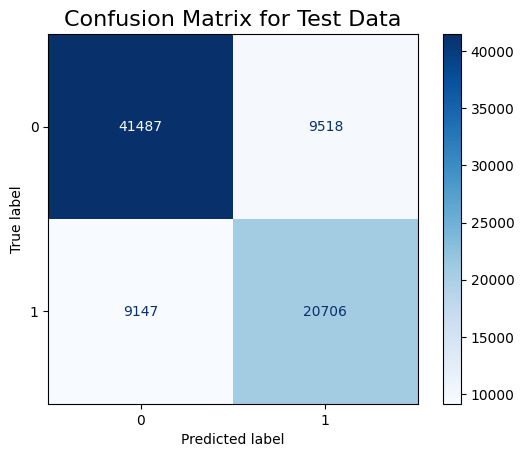

In [ ]:
# Confusion matrix for train data
y_pred_classes_test = plot_confusion_matrix_lstm(siamese_network, X1_test, X2_test, y_test, "Test")

In [ ]:
predictions = siamese_network.predict([X1_test, X2_test])
y_pred_classes_test = (predictions > optimal_threshold).astype(int).flatten()

print(classification_report(y_test,y_pred_classes_test))

2527/2527 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
              precision    recall  f1-score   support

           0       0.82      0.81      0.82     51005
           1       0.69      0.69      0.69     29853

    accuracy                           0.77     80858
   macro avg       0.75      0.75      0.75     80858
weighted avg       0.77      0.77      0.77     80858



## On Test file

In [ ]:
#load_test = pd.read_csv('/content/drive/MyDrive/NLP_Masters/Project/quora-question-pairs 2/test.csv')

In [ ]:
#test_model_data = load_test.sample(10)

In [ ]:
# Load the test dataset
test_data_1 = pd.read_csv('/content/drive/MyDrive/NLP_Masters/Project/quora-question-pairs 2/test.csv')

# Sample 10 rows from the test dataset
test_model_data = test_data_1.sample(10)

In [ ]:
import pandas as pd
from IPython.display import HTML
# Prepare results container
results = []
# Loop through each sampled test pair
for ind in test_model_data.index:
    # Tokenize question pairs
    input_ids1 = pad_sequences(
        tokenizer.texts_to_sequences(test_model_data['question1']),
        maxlen=40,
        padding='post',
        truncating='post'
    )
    input_ids2 = pad_sequences(
        tokenizer.texts_to_sequences(test_model_data['question2']),
        maxlen=40,
        padding='post',
        truncating='post'
    )


    # Predict similarity
    prediction = siamese_network.predict([input_ids1, input_ids2])

    # Determine prediction label
    prediction_text = 'Not Similar' if prediction[0][0] <= 0.5 else 'Similar'

    # Append results
    results.append((test_model_data['question1'][ind], test_model_data['question2'][ind], prediction_text))

# Convert results to a DataFrame for display
df = pd.DataFrame(results, columns=['First Sentence', 'Second Sentence', 'Predicted Output'])
display(HTML(df.to_html(index=False)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


First Sentence,Second Sentence,Predicted Output
What is the source of the titles energy of the universe?,Can I be source of energy that create universe?,Similar
Is express email marketing good for a small business?,Is email marketing good for small businesses?,Similar
"What's the difference between ""had been"" and astrologer ""were""?","If there I determine when to use had, have, had been etc?",Similar
How did your 500 opinion of Orthodox Jews change from reading about them in the press to actually getting to know them personally?,How do two or more alters become a single alter in a wear with dissociative identity disorder - what is the process and how does it feel?,Similar
"Do plants ""three pain?",What do feel pain when leaves are cut?,Similar
"If Trump is convicted of india crime in the next few weeks, would that mean Pence would become president?",Why did companies dnt hire a graduate who start finding a job after 2 years even though he/she has a good knowledge become then currently pass out students?,Similar
Can reverse BREXIT?,"Is there any possible way or couldn option for Britain to reverse ""The Brexit""?",Similar
"I like this girl, and I won't mind waiting a lifetime for her. How can I tell I like her without ruining our friendship?",How should I tell her that I like her without ruining relationship?,Similar
What are the places in India where you can get accommodation and/or food for (almost) free?,What are the places in India where you can get accommodation and food for free life long?,Similar
Which city year project I can choose for my B.Tech Mechanical engineering?,How do for mechanical engineering final year project?,Similar
